In [11]:
import networkx as nx
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
file_path = '/content/drive/MyDrive/labelling_file.csv'
df = pd.read_csv(file_path)

In [13]:
result_counts = df['result'].value_counts()
print("Result Counts:")
print(result_counts)


Result Counts:
0    380
2    307
3    258
4    169
1    147
Name: result, dtype: int64


In [15]:
import random
import numpy as np
import torch

#무작위 시드 설정
rd_seed = 42

torch.manual_seed(rd_seed)
np.random.seed(rd_seed)
random.seed(rd_seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
import pandas as pd
train_df = pd.read_csv('/content/drive/MyDrive/labelling_file.csv')

train_df.head()

In [ ]:
train_df.info()

In [23]:
!pip install torch_geometric

In [24]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

#특징 추출 정의
class GraphFeature(nn.Module):
    def __init__(self, node_feat, embed_dim):
        super(GraphFeature, self).__init__()

        self.conv_l1 = GCNConv(node_feat, 8)
        self.conv_l2 = GCNConv(8, 16)
        self.embedding = nn.Linear(16, embed_dim)

    def forward(self, x, edge_idx, batch):
        x = F.elu(self.conv_l1(x, edge_idx))
        x = F.elu(self.conv_l2(x, edge_idx))

        x = global_mean_pool(x, batch) # read-out layer

        x = self.embedding(x)

        return x

In [25]:
!pip install pytorch-tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.3 MB/s eta 0:00:00


In [26]:
from pytorch_tabnet.tab_network import AttentiveTransformer, FeatTransformer

#TabNet 인코더 정의
##TabNet은 테이블 데이터를 다루는 트랜스포머 기반 신경망
class TabNetEncoder(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_d=8,
        n_a=8,
        n_steps=3,
        gamma=1.3,
        n_independent=2,
        n_shared=2,
        epsilon=1e-15,
        virtual_batch_size=128,
        momentum=0.02,
        mask_type="sparsemax",
        group_attention_matrix=None,
        device='cpu'
    ):

        super(TabNetEncoder, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.is_multi_task = isinstance(output_dim, list)
        self.n_d = n_d
        self.n_a = n_a
        self.n_steps = n_steps
        self.gamma = gamma
        self.epsilon = epsilon
        self.n_independent = n_independent
        self.n_shared = n_shared
        self.virtual_batch_size = virtual_batch_size
        self.mask_type = mask_type
        self.initial_bn = nn.BatchNorm1d(self.input_dim, momentum=0.01)
        self.group_attention_matrix = group_attention_matrix
        self.device = device

        if self.group_attention_matrix is None:
            # no groups
            self.group_attention_matrix = torch.eye(self.input_dim).to(self.device)
            self.attention_dim = self.input_dim
        else:
            self.attention_dim = self.group_attention_matrix.shape[0]

        if self.n_shared > 0:
            shared_feat_transform = nn.ModuleList()
            for i in range(self.n_shared):
                if i == 0:
                    shared_feat_transform.append(
                        nn.Linear(self.input_dim, 2 * (n_d + n_a), bias=False)
                    )
                else:
                    shared_feat_transform.append(
                        nn.Linear(n_d + n_a, 2 * (n_d + n_a), bias=False)
                    )

        else:
            shared_feat_transform = None

        self.initial_splitter = FeatTransformer(
            self.input_dim,
            n_d + n_a,
            shared_feat_transform,
            n_glu_independent=self.n_independent,
            virtual_batch_size=self.virtual_batch_size,
            momentum=momentum,
        )

        self.feat_transformers = nn.ModuleList()
        self.att_transformers = nn.ModuleList()

        for step in range(n_steps):
            transformer = FeatTransformer(
                self.input_dim,
                n_d + n_a,
                shared_feat_transform,
                n_glu_independent=self.n_independent,
                virtual_batch_size=self.virtual_batch_size,
                momentum=momentum,
            )
            attention = AttentiveTransformer(
                n_a,
                self.attention_dim,
                group_matrix=group_attention_matrix,
                virtual_batch_size=self.virtual_batch_size,
                momentum=momentum,
                mask_type=self.mask_type,
            )
            self.feat_transformers.append(transformer)
            self.att_transformers.append(attention)

    def forward(self, x, prior=None):
        x = self.initial_bn(x)

        bs = x.shape[0]  # batch size
        if prior is None:
            prior = torch.ones((bs, self.attention_dim)).to(x.device)

        M_loss = 0
        att = self.initial_splitter(x)[:, self.n_d :]
        steps_output = []
        for step in range(self.n_steps):
            M = self.att_transformers[step](prior, att)
            M_loss += torch.mean(
                torch.sum(torch.mul(M, torch.log(M + self.epsilon)), dim=1)
            )
            # update prior
            prior = torch.mul(self.gamma - M, prior)
            # output
            M_feature_level = torch.matmul(M, self.group_attention_matrix)
            masked_x = torch.mul(M_feature_level, x)
            out = self.feat_transformers[step](masked_x)
            d = nn.ReLU()(out[:, : self.n_d])
            steps_output.append(d)
            # update attention
            att = out[:, self.n_d :]

        M_loss /= self.n_steps
        return steps_output, M_loss

    def forward_masks(self, x):
        x = self.initial_bn(x)
        bs = x.shape[0]  # batch size
        prior = torch.ones((bs, self.attention_dim)).to(x.device)
        M_explain = torch.zeros(x.shape).to(x.device)
        att = self.initial_splitter(x)[:, self.n_d :]
        masks = {}

        for step in range(self.n_steps):
            M = self.att_transformers[step](prior, att)
            M_feature_level = torch.matmul(M, self.group_attention_matrix)
            masks[step] = M_feature_level
            # update prior
            prior = torch.mul(self.gamma - M, prior)
            # output
            masked_x = torch.mul(M_feature_level, x)
            out = self.feat_transformers[step](masked_x)
            d = nn.ReLU()(out[:, : self.n_d])
            # explain
            step_importance = torch.sum(d, dim=1)
            M_explain += torch.mul(M_feature_level, step_importance.unsqueeze(dim=1))
            # update attention
            att = out[:, self.n_d :]

        return M_explain, masks

In [27]:
#그래프와 테이블 데이터를 함께 사용

class GraphTab(nn.Module):
    def __init__(self, graph_dict, tabnet_dict, num_heads, reg_emb, drop_ratio, out_dim, device='cpu'):
        super(GraphTab, self).__init__()

        self.device = device

        self.graph_feature = GraphFeature(graph_dict['node_feat'], graph_dict['embed_dim'])
        self.tabnet_feature = TabNetEncoder(input_dim =     tabnet_dict['input_dim'],
                                            output_dim =    tabnet_dict['output_dim'],
                                            n_d =           tabnet_dict['n_da'],
                                            n_a =           tabnet_dict['n_da'],
                                            n_steps =       tabnet_dict['n_steps'],
                                            device =        self.device)

        self.attn_layer = nn.MultiheadAttention(graph_dict['embed_dim'], num_heads, dropout=drop_ratio)

        self.regressor = nn.Sequential(nn.Linear(graph_dict['embed_dim'], reg_emb),
                                       nn.BatchNorm1d(reg_emb),
                                       nn.ELU(),
                                       nn.Dropout(p=drop_ratio),
                                       nn.Linear(reg_emb, reg_emb),
                                       nn.BatchNorm1d(reg_emb),
                                       nn.ELU(),
                                       nn.Dropout(p=drop_ratio),
                                       nn.Linear(reg_emb, out_dim))

    def forward(self, node_attr, edge_idx, batch, tabular):
        gr_ft = self.graph_feature(node_attr, edge_idx, batch) # (batch, embed_dim)
        tab_ft = self.tabnet_feature(tabular) # return tuple(list of tensor (batch, n_a))

        tab_ft = torch.sum(torch.stack(tab_ft[0]), dim=0)
        # tab_ft = torch.squeeze(tab_ft, 0)

        gr_ft.to(self.device)
        tab_ft.to(self.device)

        attn_output = self.attn_layer(gr_ft, gr_ft, tab_ft) # (batch, pos_emb)
        attn_output = attn_output[0]

        res = self.regressor(attn_output)
        return res

In [57]:
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

#데이터셋 정의
class CPGDataset(Dataset):
    def __init__(self, csv_file):
        super(CPGDataset, self).__init__()

        self.train_df = pd.read_csv(csv_file)
        self.train_df.fillna(0, inplace=True)
        self.graph_list = self.cpgs2graph(self.train_df['nodes'], self.train_df['edges'], self.train_df['time'])

        self.target_result = torch.tensor(self.train_df['time'].values.astype(np.float32))
        self.wo_cpgs_df = self.train_df.drop(columns=['index', 'nodes', 'edges', 'time'])
        self.wo_cpgs_df = torch.tensor(self.wo_cpgs_df.values.astype(np.float32))

    def cpgs2graph_single(self, nodes, edges, time):
        # 노드 및 엣지 정보 추출
        nodes_info = [node.split(':') for node in nodes.split('|') if node]

        if isinstance(edges, str):
            edges_info = [edge.split('->') for edge in edges.split('|') if edge]
        elif isinstance(edges, int):
            edges_info = []
        else:
            raise ValueError("Invalid type for 'edges'. Should be either str or int.")

        # 그래프 생성
        G = nx.Graph()

        # 노드 추가
        for node_info in nodes_info:
            if len(node_info) > 1:  # 노드 정보가 제대로 있다면
                G.add_node(node_info[0], feature=node_info[1])

        # 엣지 추가
        for edge_info in edges_info:
            # 엣지 특성을 추가
            if len(edge_info) > 1:
                source, target_feature = edge_info[0], edge_info[1].split(':')
                if len(target_feature) > 1:
                    target, feature = target_feature[0], target_feature[1]
                    G.add_edge(source, target, feature=feature)
                else:
                    print("Error: Edge feature is missing.")
            else:
                print("Error: Incomplete edge information.")

        # 그래프에 'time' 라벨 추가
        G.graph['time'] = time

        return G

    def cpgs2graph(self, nodes_list, edges_list, time_list):
        print('Convert "CPG"csv to graph')

        graph_list = []
        for nodes, edges, time in zip(nodes_list, edges_list, time_list):
            try:
                # nodes와 edges를 그래프로 변환
                G = self.cpgs2graph_single(nodes, edges, time)
                graph_list.append(G)
            except Exception as e:
                print(f"Error creating graph: {e}")

        print('Complete!')
        return graph_list

    def visualize_graph(self, G):
        pos = nx.spring_layout(G)  # 레이아웃 결정

        # 노드 및 엣지 시각화
        nx.draw_networkx_nodes(G, pos, node_size=700)
        nx.draw_networkx_edges(G, pos)
        nx.draw_networkx_labels(G, pos)

        # 엣지에 대한 특성 시각화
        edge_labels = nx.get_edge_attributes(G, 'feature')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

        # 그래프에 'time' 라벨 추가
        plt.title(f"Graph with time: {G.graph['time']}")
        plt.show()

    def __getitem__(self, idx):
        return self.graph_list[idx], self.wo_cpgs_df[idx], self.target_result[idx]

    def __len__(self):
        return len(self.graph_list)


Convert "CPG"csv to graph
Error: Incomplete edge information.
Error: Edge feature is missing.
Complete!

1263
Visualizing Graph 1


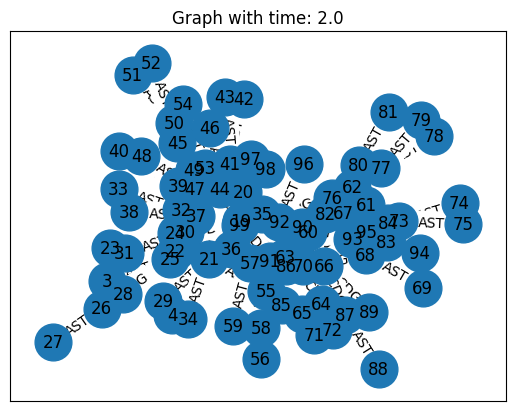

Visualizing Graph 2


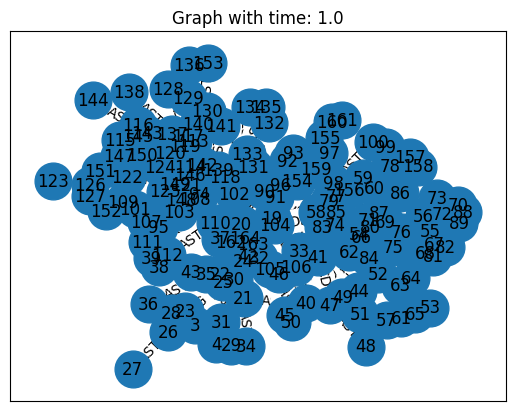

Visualizing Graph 3


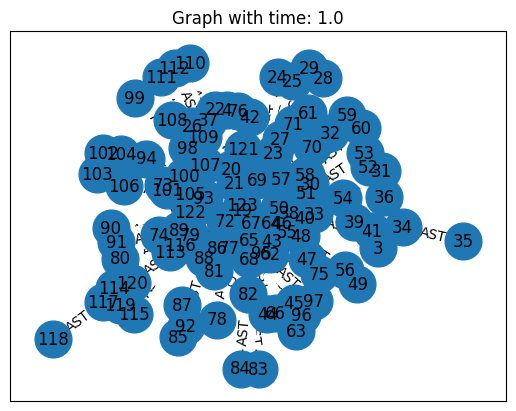

Visualizing Graph 4


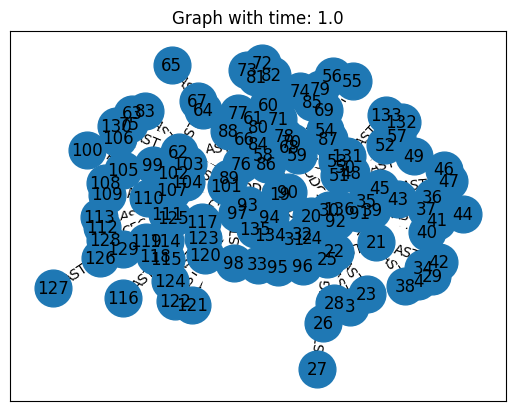

Visualizing Graph 5


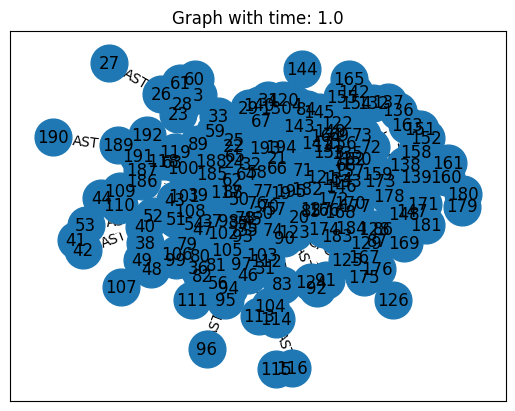

Visualizing Graph 6


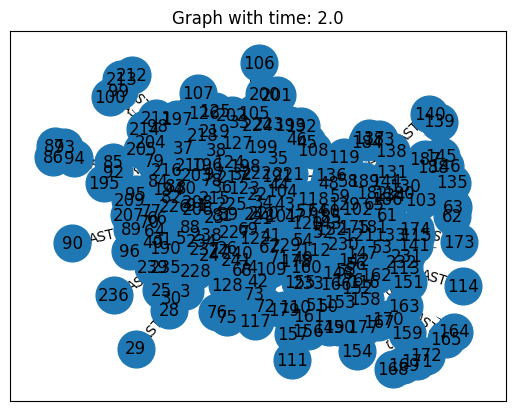

Visualizing Graph 7


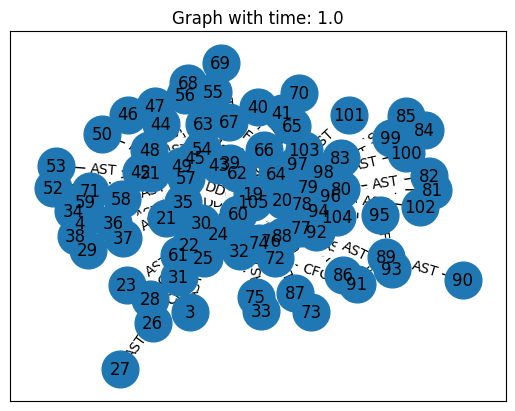

Visualizing Graph 8


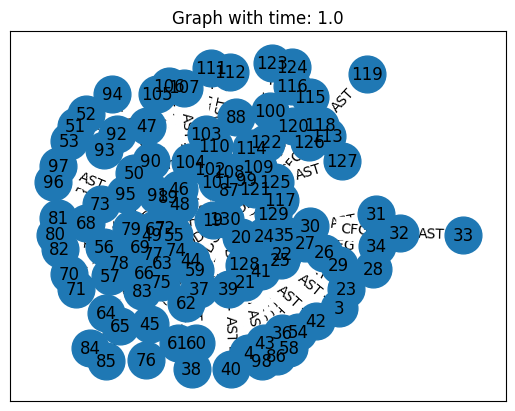

Visualizing Graph 9


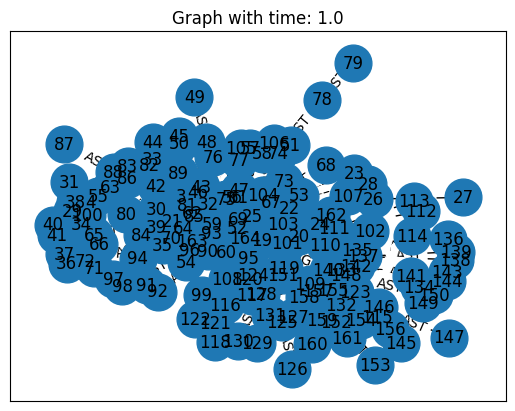

Visualizing Graph 10


KeyboardInterrupt: ignored

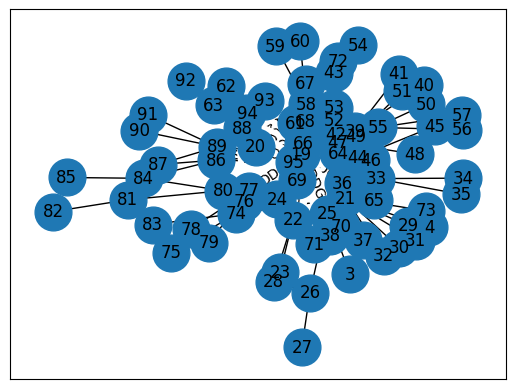

In [58]:
test_dataset = CPGDataset('/content/drive/MyDrive/labelling_file.csv')
test_loader = DataLoader(test_dataset, batch_size=128)

print()
print(len(test_dataset))

for i, graph in enumerate(test_dataset.graph_list):
    print(f"Visualizing Graph {i + 1}")
    test_dataset.visualize_graph(graph)